# Modèle CNN

## Imports

In [64]:
import os
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Connexion à la BDD

In [65]:
import os

# Chemin absolu corrigé
db_path = os.path.abspath("../db.sqlite3")

print("Connexion à :", db_path)

# Connexion
conn = sqlite3.connect(db_path)

# Vérifie les tables présentes
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables présentes :", tables)

Connexion à : /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Solution Delivery/SolutionDelivery_PRJ/backend/src/db.sqlite3
Tables présentes : [('Image',), ('Location',), ('ClassificationConstraints',), ('sqlite_sequence',)]


## Charger TRAIN dataset

In [66]:
query_train = "SELECT Id_Image, File_path, Status FROM Image WHERE Id_Image > 100"
df_train = pd.read_sql_query(query_train, conn)

print(f"Nombre d'images train : {len(df_train)}")
df_train.head()

Nombre d'images train : 600


,Id_Image,File_path,Status
0,101,train/no_label/WhatsApp Image 2020-08-25 at 12...,1
1,102,train/no_label/WhatsApp Image 2020-10-26 at 9....,1
2,103,train/no_label/WhatsApp Image 2020-10-26 at 9....,0
3,104,train/no_label/WhatsApp Image 2020-08-20 at 7....,0
4,105,train/no_label/WhatsApp Image 2020-07-11 at 5....,1


## Fonction de chargement + preprocessing

In [67]:
def load_and_preprocess(img_path, target_size=(128,128)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return img_array

## Charger toutes les images train

In [68]:
import os
from pathlib import Path

images_train = []
labels_train = []

for _, row in df_train.iterrows():
    img_path = os.path.join('../../src/media/Data', row['File_path'])
    img_path = os.path.abspath(img_path)  # chemin absolu pour vérification

    # Vérification d'existence et debug
    if os.path.exists(img_path):
        images_train.append(load_and_preprocess(img_path))
        labels_train.append(row['Status'])
    else:
        print(f"⚠️ Image manquante : {img_path}")
        print(f"   ➜ Vérifiez si le fichier existe réellement à cet emplacement.")

# Convertir en array
X = np.array(images_train)
y = np.array(labels_train)

print("✅ Chargement terminé")
print("Shape X :", X.shape)
print("Shape y :", y.shape)

✅ Chargement terminé
Shape X : (600, 128, 128, 3)
Shape y : (600,)


## Split train / validation

In [69]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train :", X_train.shape, "Val :", X_val.shape)

Train : (480, 128, 128, 3) Val : (120, 128, 128, 3)


## Construction du modèle CNN

In [70]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,921 (14.14 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

## Entraînement

In [71]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.4900 - loss: 1.1334 - val_accuracy: 0.4750 - val_loss: 0.6892
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5077 - loss: 0.6849 - val_accuracy: 0.5500 - val_loss: 0.6542
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.6853 - loss: 0.6030 - val_accuracy: 0.5500 - val_loss: 0.6666
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7611 - loss: 0.5188 - val_accuracy: 0.6667 - val_loss: 0.6210
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7947 - loss: 0.4258 - val_accuracy: 0.6667 - val_loss: 0.6278
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8345 - loss: 0.3523 - val_accuracy: 0.6917 - val_loss: 0.6901
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8826 - loss: 0.3017 - val_accuracy: 0.6667 - val_loss: 0.8321
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9022 - loss: 0.2414 - val_accuracy: 0.6917 - v

## Sauvegarder le modèle entraîné

In [72]:
model.save("trashmap_cnn.keras")
print("✅ Modèle sauvegardé sous trashmap_cnn.h5")

✅ Modèle sauvegardé sous trashmap_cnn.h5


## Évaluation sur validation

In [73]:
y_pred_val = (model.predict(X_val) > 0.5).astype("int32")

print("Classification Report :")
print(classification_report(y_val, y_pred_val))

print("Confusion Matrix :")
print(confusion_matrix(y_val, y_pred_val))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Classification Report :
              precision    recall  f1-score   support

           0       0.66      0.79      0.72        63
           1       0.70      0.54      0.61        57

    accuracy                           0.68       120
   macro avg       0.68      0.67      0.67       120
weighted avg       0.68      0.68      0.67       120

Confusion Matrix :
[[50 13]
 [26 31]]


## Visualiser l’apprentissage

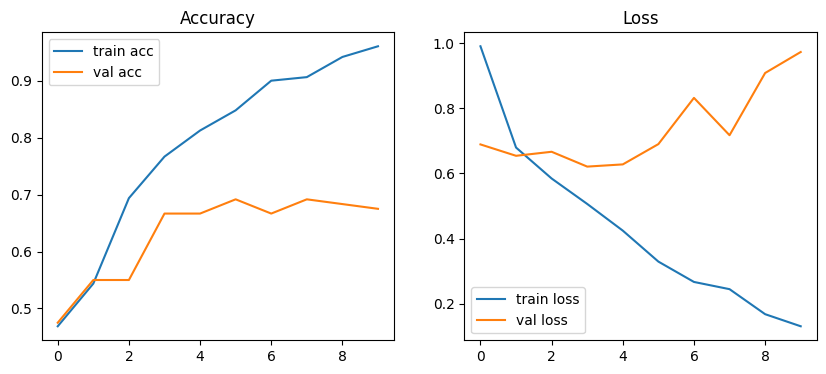

In [74]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss")
plt.show()

## TEST set : charger et prédire

In [75]:
import os
from pathlib import Path

images_test = []
labels_test = []

for _, row in df_test.iterrows():
    img_path = os.path.join('../../src/media/Data', row['File_path'])
    img_path = os.path.abspath(img_path)  # chemin absolu pour vérification

    if os.path.exists(img_path):
        images_test.append(load_and_preprocess(img_path))
        labels_test.append(row['Status'])
    else:
        print(f"⚠️ Image manquante : {img_path}")
        print(f"   ➜ Vérifiez si le fichier existe réellement à cet emplacement.")

X_test = np.array(images_test)
y_test = np.array(labels_test)

print("✅ Test set loaded :", X_test.shape)


✅ Test set loaded : (100, 128, 128, 3)


## Prédictions TEST set

In [76]:
y_pred_test = (model.predict(X_test) > 0.5).astype("int32")

print("Classification Report TEST :")
print(classification_report(y_test, y_pred_test))

print("Confusion Matrix TEST :")
print(confusion_matrix(y_test, y_pred_test))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Classification Report TEST :
              precision    recall  f1-score   support

           0       0.71      0.76      0.74        51
           1       0.73      0.67      0.70        49

    accuracy                           0.72       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.72      0.72      0.72       100

Confusion Matrix TEST :
[[39 12]
 [16 33]]
